In [1]:
import matplotlib. pyplot as plt
import re
import pandas as pd
import random as random
import seaborn as sns
plt.rc('figure', figsize=(15, 6))

In [2]:
%matplotlib inline

In [3]:
summary = pd.read_csv("atusdata/atussum_2013/atussum_2013.dat")
summary.head()

,tucaseid,TUFINLWGT,TRYHHCHILD,TEAGE,TESEX,PEEDUCA,PTDTRACE,PEHSPNON,GTMETSTA,TELFS,...,t181501,t181599,t181601,t181801,t189999,t500101,t500103,t500105,t500106,t500107
0,20130101130004,11899905.662034,12,22,2,40,8,2,1,5,...,0,0,0,0,0,0,0,0,0,0
1,20130101130112,4447638.009513,1,39,1,43,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
2,20130101130123,10377056.507734,-1,47,2,40,1,2,1,4,...,25,0,0,0,0,0,0,0,0,0
3,20130101130611,7731257.992805,-1,50,2,40,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,20130101130616,4725269.227067,-1,45,2,40,2,2,1,1,...,0,0,0,0,0,0,0,0,0,0


In [34]:
def education_mapping(code):
    if code <= 38:
        return 0 # Did not graduate HS
    elif code <= 41:
        return 1 # HS grad
    elif code == 43:
        return 2 # Bachelor's
    elif code >= 44:
        return 3 # Graduate degree(s)

times_of_interest_codes = {"Travel": "18",
                           "Work Travel": "1805",
                           "Eating Travel": "1811",
                           "Religious Activity": "14",
                           "Eating and Drinking": "11",
                           "Education": "06",
                           "Work": "05",
                           "Working": "0501",
                           "Housework": "0201",
                           "Laundry": "020102",
                           "Billiards": "130105",
                           "Food Prep and Cleanup": "0202",
                           "Sleep": "0101",
                           "Grooming": "0102"}
times_of_interest = list(times_of_interest_codes.keys())
group_divisions_of_interest = {"Sex": "TESEX",
                               "Age": "TEAGE",
                               "Education": "PEEDUCA"}
groups_of_interest = list(group_divisions_of_interest.keys())
divisions_of_interest = {"adults_crit":  (summary.TEAGE >= 18),
                         "no_children_crit": (summary.TRCHILDNUM == 0)}
plot_bars = {"Sex", 'Education'}
group_labels = {"Sex": ["Male", "Female"]}
groupings = {'Sex': {'column': 'TESEX',
                     'labels': ["Male", "Female"]},
             'Age': {'column': 'TEAGE'},
             'Education': {'column': 'PEEDUCA',
                           'mapping': education_mapping,
                           'labels': ['No HS degree', 'HS Degree', "Bachelor's", 'Graduate degree(s)']}}

In [5]:
random.choice(times_of_interest)

'Religious Activity'

In [6]:
random.choice(groups_of_interest)

'Sex'

In [7]:
data_subset = summary[["TUFINLWGT","TESEX", "t130105"]]

In [8]:
data_subset["billiards"] = data_subset.t130105 * data_subset.TUFINLWGT

-c:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
male_female = data_subset.groupby(["TESEX"])

In [10]:
male_female_billiards = data_subset['billiards'].groupby(data_subset['TESEX'])

In [11]:
male_female_weights = data_subset['TUFINLWGT'].groupby(data_subset['TESEX'])

In [12]:
male_female_diff = male_female_billiards.sum() / male_female_weights.sum()

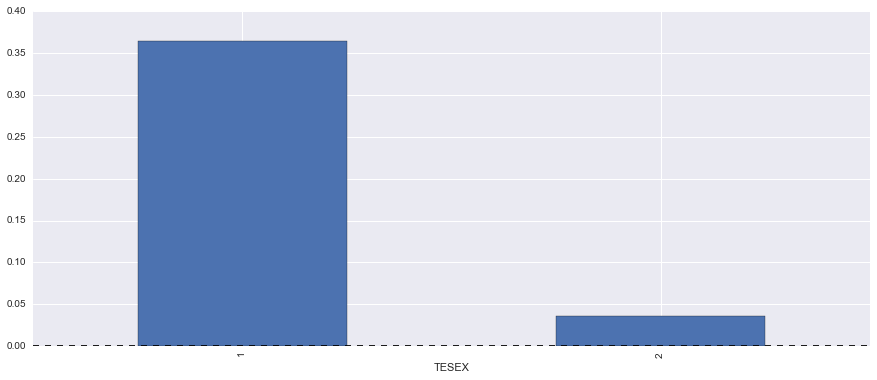

In [13]:
male_female_diff.plot(kind='bar', figsize=(15, 6))

In [29]:
def activity_columns(data, activity_code):
    """For the activity code given, return all columns that fall under that activity."""
    col_prefix = "t{}".format(activity_code)
    return [column for column in data.columns if re.match(col_prefix, column)]

def generate_diffs(data, group_key, activity_key):
    group = groupings[group_key]
    # Get group column
    gcol = group['column']
    # Do we need to map?
    if 'mapping' in group:
        data[gcol + '_map'] = data[gcol].map(group['mapping'])
        gcol = gcol + '_map'
    # - If so, make a new column with mappings
    time = times_of_interest_codes[activity_key]
    time_columns = activity_columns(data, time)
    data_subset_list = ["TUFINLWGT", gcol] + time_columns
    data_subset = data[data_subset_list]
    data_subset[activity_key] = data_subset[time_columns].sum(axis=1) * data_subset.TUFINLWGT
    grouped_data = data_subset.groupby([gcol])
    grouped_data_diff = grouped_data[activity_key].sum() / grouped_data['TUFINLWGT'].sum()
    return grouped_data_diff
    
    
def plot_diffs(data, group_key, activity_key):    
    group = groupings[group_key]
    if group_key in plot_bars:
        data.plot(figsize=(15, 6), kind='bar')
    else:
        data.plot(figsize=(15, 6))
        
    if 'labels' in group:
        plt.xticks(range(len(group['labels'])), group['labels'])
    plt.title("Time spent on " + activity_key + " by " + group_key)
    plt.ylabel(activity_key + " (minutes)")
    plt.xlabel(group_key)
    plt.show()
    
# P

In [30]:
def generate_random_plot():
    time = random.choice(times_of_interest)
    group = random.choice(groups_of_interest)
    data = generate_diffs(summary, group, time)
    plot_diffs(data, group, time)

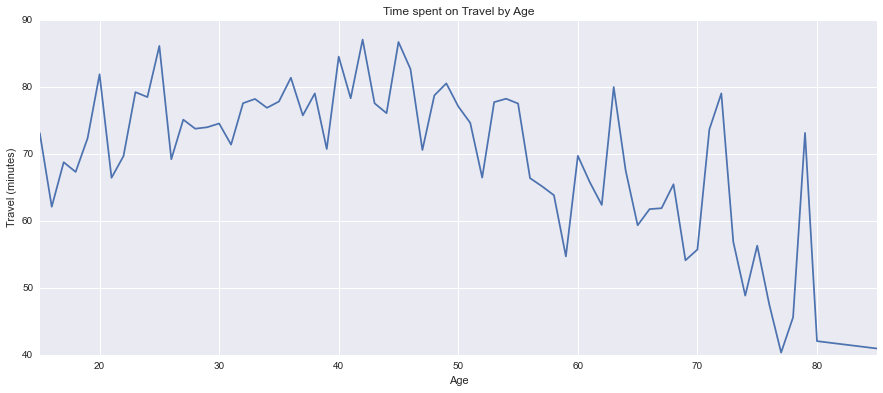

In [40]:
generate_random_plot()

In [39]:
adults_crit = (summary.TEAGE >= 18)
no_children_crit = (summary.TRCHILDNUM == 0)

In [18]:
adults_with_children = adults_crit & ~ no_children_crit